## Loading files and Environment

This notebook will be separated out.

In [1]:
#%conda env export > environment.yml

In [26]:
import os
import glob
import pandas as pd
import numpy as np
import sys
import pathlib
import sklearn
import numpy
import nltk
from dotenv import load_dotenv
import wordcloud
import gensim
import scipy.stats as stats
from wordcloud import WordCloud
from sklearn.metrics import classification_report
from sklearn.datasets import load_iris
from PIL import Image, ImageDraw, ImageFont
from nltk.corpus import stopwords
from collections import Counter
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_fscore_support

In [3]:
# Get current directory
current_dir = os.getcwd()
# Get parent directory
parent_dir = os.path.join(current_dir, '..')
# Append parent directory to sys.path
sys.path.append(parent_dir)

In [4]:
from src.aspect_classification.data.data_cleaning import cleaning_selector

In [5]:
cwd = pathlib.Path.cwd().parent
training_file_path = cwd.joinpath("data/raw/train/EuansGuideData.xlsx")
test_file_path = cwd.joinpath("data/raw/test/GoogleReviews")
print('path:', training_file_path)
print('path:', test_file_path)

path: /Users/mylene/BachelorsProject/Venue-Accessibility-Google-Reviews/data/raw/train/EuansGuideData.xlsx
path: /Users/mylene/BachelorsProject/Venue-Accessibility-Google-Reviews/data/raw/test/GoogleReviews


In [6]:
all_file_names = glob.glob(str(test_file_path) + "/*.csv")
google_df = [pd.read_csv(file_name, index_col=None, header=0) for file_name in all_file_names]
test_data = pd.concat(google_df, axis=0, ignore_index=True)

## Cleaning & Preprocessing

In [7]:
training_data = pd.read_excel(training_file_path)
clean_train_df = cleaning_selector(training_data, ["Aspect", "Rating", "Review", "Venue"])
clean_test_df = cleaning_selector(test_data, ["Name","Review Rate", "Review Text"])

                Aspect  Rating  \
0             Overview     5.0   
1  Transport & Parking     5.0   
2               Access     5.0   
3              Toilets     0.0   
4                Staff     3.5   

                                                Text  \
0  Dobbies garden center has a large range of ite...   
1  There is disabled parking close to the doors, ...   
2  There is a lift and there is also a cafe where...   
3                                                NaN   
4  There were some staff who were very helpful an...   

                                               Venue  
0  https:||www.euansguide.com|venues|dobbies-gard...  
1  https:||www.euansguide.com|venues|dobbies-gard...  
2  https:||www.euansguide.com|venues|dobbies-gard...  
3  https:||www.euansguide.com|venues|dobbies-gard...  
4  https:||www.euansguide.com|venues|dobbies-gard...  


/Users/mylene/BachelorsProject/Venue-Accessibility-Google-Reviews/notebooks/../src/aspect_classification/data/data_cleaning.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Text"] = df["Text"].apply(lambda x: x.replace("\n", ' '))


In [8]:
import string
translator = str.maketrans('', '', string.punctuation+'\u2026')

def remove_small_words(sentence):
   
    if len(nltk.word_tokenize(sentence.translate(translator))) >= 5:
       return sentence
    else:
       return "useless"


In [9]:
import re

pattern = r'\(Translated by Google\)|\(Original\)'  # Define the regular expression pattern
clean_test_df['Text'] = clean_test_df['Text'].str.replace(pattern, '', regex=True)

In [10]:
clean_test_df[400:].head()

,Name,Sentiment,Text
792,House of Watt,negative,nowadays no coffee workplace but you can only...
793,House of Watt,negative,"Nicely dressed, but the prices are high, I ha..."
794,House of Watt,positive,"Hidden gem; delicious brisket burgers, cozy a..."
795,House of Watt,positive,House of Watt is close to the Amstel station....
796,House of Watt,positive,Super place to watch Ajax (during corona). Go...


In [11]:
sample_df = clean_test_df.assign(text=clean_test_df['Text'].apply(nltk.sent_tokenize)).explode('Text').reset_index(drop=True)
sample_df.head()

,Name,Sentiment,Text,text
0,Ellis,positive,"It was a bit quite when we went in, but don’t ...","[It was a bit quite when we went in, but don’t..."
1,Ellis,positive,Nice cozy place which serves very tasty burger...,[Nice cozy place which serves very tasty burge...
2,Ellis,positive,Really nice place. One of my favourite burger ...,"[Really nice place., One of my favourite burge..."
3,Ellis,negative,The Service was quite good but the burgers we ...,[The Service was quite good but the burgers we...
4,Ellis,positive,I had a very nice experience! The staff were r...,"[I had a very nice experience!, The staff were..."


In [12]:
sample_df = sample_df.explode('text').reset_index(drop=True)
sample_df.head()

,Name,Sentiment,Text,text
0,Ellis,positive,"It was a bit quite when we went in, but don’t ...","It was a bit quite when we went in, but don’t ..."
1,Ellis,positive,"It was a bit quite when we went in, but don’t ...",After a little while the place was cozily busy.
2,Ellis,positive,"It was a bit quite when we went in, but don’t ...",Rightfully so!
3,Ellis,positive,"It was a bit quite when we went in, but don’t ...","The burgers (and nachos) were lovely, as was t..."
4,Ellis,positive,"It was a bit quite when we went in, but don’t ...",I would definitely recommend this place if you...


In [13]:
sample_df = sample_df.drop('Text', axis=1)
sample_df.head()

,Name,Sentiment,text
0,Ellis,positive,"It was a bit quite when we went in, but don’t ..."
1,Ellis,positive,After a little while the place was cozily busy.
2,Ellis,positive,Rightfully so!
3,Ellis,positive,"The burgers (and nachos) were lovely, as was t..."
4,Ellis,positive,I would definitely recommend this place if you...


In [14]:
sample_df['text'] = sample_df['text'].apply(remove_small_words)

In [15]:
sample_df.head()

,Name,Sentiment,text
0,Ellis,positive,"It was a bit quite when we went in, but don’t ..."
1,Ellis,positive,After a little while the place was cozily busy.
2,Ellis,positive,useless
3,Ellis,positive,"The burgers (and nachos) were lovely, as was t..."
4,Ellis,positive,I would definitely recommend this place if you...


In [16]:
sample_df = sample_df[sample_df['text'].str.contains("useless") == False]

In [17]:
reg_pattern = r".*([Pp]ancakes|[Dd]rink|[Dd]esserts|[Gg]in|[Ww]ine|[Bb]reakfast|[Ll]unch|[Pp]asta|[Vv]egeterian|[Vv]egan|[Bb]urgers|[Pp]asta|[Dd]ish|[Bb]eer|[Pp]izza|[Tt]aste|[Ff]ood|[Cc]ocktail|[Cc]offee|[Mm]enu|[Tt]asty|[Dd]elicious|[Ss]taff|[Hh]ost|[Aa]mbience|[Aa]tmosphere|[Cc]o[sz]y|[Gg]ezellig|[Ss]ervice]|[Pp]rice[y]|[Cc]heap|([Nn]ice|[Gg]reat|[Aa]mazing) place|([Gg]ood|[Bb]ad|[Tt]errible|[Gg]reat) experience).*"

mask = sample_df['text'].str.contains(reg_pattern)

/var/folders/qk/lcnvt9x13sd1_944mzdqthnh0000gn/T/ipykernel_89967/4205323225.py:3: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = sample_df['text'].str.contains(reg_pattern)


In [18]:
sample_df = sample_df[~mask]

In [19]:
sample_df.head()

,Name,Sentiment,text
0,Ellis,positive,"It was a bit quite when we went in, but don’t ..."
1,Ellis,positive,After a little while the place was cozily busy.
4,Ellis,positive,I would definitely recommend this place if you...
8,Ellis,positive,The best thing is you can even get a gluten-fr...
11,Ellis,positive,One of my favourite burger joints whole visiti...


In [20]:
# from nltk.corpus import wordnet as wn

# # define a function to check if a word is related to food or drink
# def is_food_or_drink(word):
#     food_synsets = wn.synsets('food')
#     drink_synsets = wn.synsets('drink')
#     food_and_drink_words = set()
#     for synset in food_synsets + drink_synsets:
#         for lemma in synset.lemmas():
#             food_and_drink_words.add(lemma.name())
#     other_food_and_drink_words = {'breakfast', 'lunch', 'dinner', 'alcohol'}
#     food_and_drink_words |= other_food_and_drink_words
#     return word in food_and_drink_words

# # identify the rows that contain food or drink related words
# food_rows = []
# for i, row in sample_df.iterrows():
#     for word in nltk.word_tokenize(row['text']):
#         if is_food_or_drink(word):
#             food_rows.append(i)

# # drop the rows that contain food or drink related words
# sample_df.drop(food_rows, inplace=True)

In [21]:
google_random_sample = sample_df.sample(frac=0.02, random_state=42)

In [22]:
print((google_random_sample).shape[0])

5602


In [28]:
# Load environment variables from .env file
load_dotenv()
google_random_sample.to_excel(os.getenv('LOCAL_ENV') + 'data/processed/experiments/labelling_sample.xlsx')

In [32]:
#sample_df.to_excel('/Users/mylene/BachelorsProject/Venue-Accessibility-Google-Reviews/datasets/11random_google_reviews_excel.xlsx')

In [33]:
# Assuming your dataframe is named df
search_terms = ['Parking', 'Transport', 'Toilets', 'Access', 'Entrance', 'Accessibility', 'Wheelchair', 'Staff']
num_rows = sample_df[sample_df['text'].str.contains('|'.join(search_terms), case=False, na=False)].shape[0]
print(f"There are {num_rows} rows that mention the search terms.")


There are 1948 rows that mention the search terms.


In [34]:
clean_test_df.head()

,Name,Sentiment,Text
0,Ellis,positive,"It was a bit quite when we went in, but don’t ..."
1,Ellis,positive,Nice cozy place which serves very tasty burger...
2,Ellis,positive,Really nice place. One of my favourite burger ...
3,Ellis,negative,The Service was quite good but the burgers we ...
4,Ellis,positive,I had a very nice experience! The staff were r...


## Exploratory Data Analysis

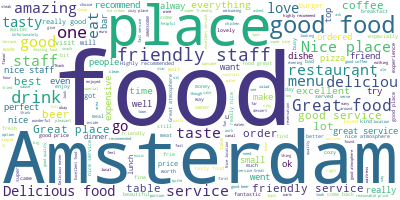

In [35]:
wordcloud = WordCloud(background_color='white', max_words=1000, contour_width=3, contour_color='steeleblue')

clustered_reviews_train = ','.join(list(clean_train_df['Text'].values))
clustered_reviews_test = ','.join(list(clean_test_df['Text'].values))
wordcloud.generate(clustered_reviews_train)
wordcloud.generate(clustered_reviews_test)
wordcloud.to_image()
wordcloud.to_image()

<AxesSubplot: title={'center': "Overview of Aspects in Euan's Guide data"}, xlabel='Aspect Types', ylabel='Amount of aspects'>

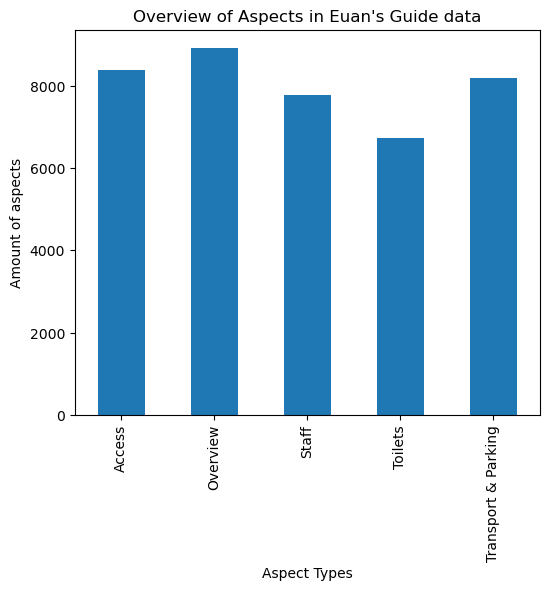

In [36]:
amount_per_aspect = clean_train_df.groupby(['Aspect']).count()
amount_per_aspect = amount_per_aspect['Text']
amount_per_aspect.plot(kind='bar', title="Overview of Aspects in Euan's Guide data", ylabel='Amount of aspects', xlabel='Aspect Types', figsize=(6,5))

In [37]:
amount_per_aspect

Aspect
Access                 8395
Overview               8921
Staff                  7790
Toilets                6724
Transport & Parking    8194
Name: Text, dtype: int64

<AxesSubplot: title={'center': "Overview of Sentiments in Euan's Guide data"}, xlabel='Sentiment Types', ylabel='Amount of Each Sentiment'>

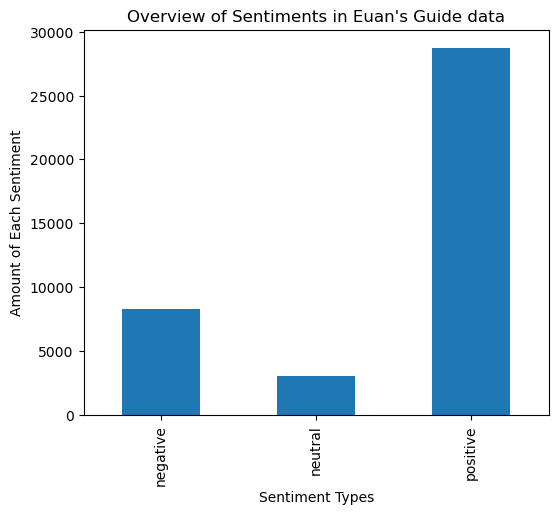

In [38]:
amount_per_sentiment = clean_train_df.groupby(['Sentiment']).count()
amount_per_sentiment = amount_per_sentiment['Text']
amount_per_sentiment.plot(kind='bar', title="Overview of Sentiments in Euan's Guide data", ylabel='Amount of Each Sentiment', xlabel='Sentiment Types', figsize=(6,5))

In [39]:
amount_per_sentiment 

Sentiment
negative     8252
neutral      3066
positive    28706
Name: Text, dtype: int64

## Aspect Classification

### Pipeline setup

In [40]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.metrics.pairwise import cosine_similarity



In [41]:
vectorizer = CountVectorizer()
n = round(len(clean_train_df))
print(n)
euans_reviews = clean_train_df.Text.values.tolist()
google_reviews = clean_test_df[:n].Text.values.tolist()
euans_labels = clean_train_df.Aspect.values.tolist()


40024


In [42]:
pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('clf', VotingClassifier([
        ('nb', MultinomialNB()),
        ('lr', LogisticRegression())
    ]))
])

In [43]:
parameters = {
    'vectorizer__max_df': (0.5, 0.75, 1.0),
    'vectorizer__ngram_range': ((1, 1), (1, 2)),
    'clf__voting': ('soft', 'hard'),
    'clf__nb__alpha': (0.5, 1),
    'clf__lr__C': (0.1, 1, 10),
}

In [44]:
grid_search = GridSearchCV(estimator=pipeline, param_grid=parameters, cv=5, n_jobs=5, verbose=3)

In [45]:
X_train, X_val, y_train, y_val = train_test_split(euans_reviews, euans_labels, test_size=0.2, random_state=42)

In [46]:
import random

google_sample = random.sample(google_reviews, len(y_val))

In [47]:
print(len(y_train))

32019


In [ ]:
grid_search.fit(X_train, y_train)

In [ ]:
y_pred = grid_search.predict(X_val)
print(len(y_pred))

In [ ]:
google_pred = grid_search.predict(google_sample)

In [ ]:
pos_labels = ['Toilets', 'Transport & Parking']

### Evaluation Metrics

In [ ]:
valuation_report = classification_report(y_val, y_pred, labels=pos_labels)
evaluation_report = classification_report(y_val, google_pred, labels=pos_labels)
print("Euan's Guide Evaluation Report\n",valuation_report)
print("Google Reviews Evaluation Report\n",evaluation_report)
# # convert text file to PNG image
img = Image.new('RGB', (800, 800), color='white')
font = ImageFont.truetype('../media/Fonts/Roboto/Roboto-Black.ttf', 20)
draw = ImageDraw.Draw(img)

with open('../Results/1google_aspect_classification_report.txt', 'r') as f:
    y = 0
    for line in f.readlines():
        draw.text((10, y), line, fill='black', font=font)
        y += 20

img.save('../Results/1google_aspect_classification_report.png')

with open('../Results/1euans_aspect_classification_report.txt', 'r') as f:
    y = 0
    for line in f.readlines():
        draw.text((10, y), line, fill='black', font=font)
        y += 20

img.save('../Results/euans_aspect_classification_report.png')


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_val, google_pred)

display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pos_labels)

display.plot()

## Sentiment Analysis

In [ ]:
sentiment_labels = clean_train_df.Sentiment.values.tolist()
X2_train, X2_val, y2_train, y2_val = train_test_split(euans_reviews, sentiment_labels, test_size=0.2, random_state=42)

pipeline2 = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('clf', VotingClassifier([
        ('nb', MultinomialNB()),
        ('svm', SVC())
    ]))
])

In [ ]:
sentiment_params = {
    'vectorizer__max_features': [1000, 5000],
    'vectorizer__ngram_range': [(1, 1), (1, 2)],
    'clf__voting': ['hard', 'soft'],
    'clf__weights': [[0.5, 0.5], [0.7, 0.3]],
    'clf__estimators': [
        [('nb', MultinomialNB(alpha=0.5)), ('svm', SVC(kernel='linear', C=1.0))],
        [('nb', MultinomialNB(alpha=1.0)), ('svm', SVC(kernel='rbf', C=10.0, gamma=0.1))]
    ]
}

In [ ]:
grid_search2 = GridSearchCV(estimator=pipeline2, param_grid=sentiment_params, cv=5, n_jobs=5, verbose=1)
grid_search2.fit(X2_train, y2_train)
y2_pred = grid_search2.predict(X2_val)
google2_pred = grid_search2.predict(google_sample)
euans_report = classification_report(y2_val, y2_pred)
google_report = classification_report(google2_pred, y2_pred)

print('Euans Report\n', euans_report)
print('Google Report\n', google_report)

In [ ]:

# # convert text file to PNG image optimise this as you repeat this code.
img = Image.new('RGB', (800, 800), color='white')
font = ImageFont.truetype('../media/Fonts/Roboto/Roboto-Black.ttf', 20)
draw = ImageDraw.Draw(img)

with open('../Results/1euans_sentiment_analysis_report.txt', 'r') as f:
    y = 0
    for line in f.readlines():
        draw.text((10, y), line, fill='black', font=font)
        y += 20

img.save('../Results/1euans_sentiment_analysis_report.png')

with open('../Results/1google_sentiment_analysis_report.txt', 'r') as f:
    y = 0
    for line in f.readlines():
        draw.text((10, y), line, fill='black', font=font)
        y += 20

img.save('../Results/google_sentiment_analysis_report.png')


In [ ]:
cm2 = confusion_matrix(y2_val, google2_pred)

display2 = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=pos_labels)

display2.plot()

## Opinion Summarisation

Moved this part to Google Colab https://colab.research.google.com/drive/1NVzQ3vS6oaQ7EPFzzij1XbjDQT0QpOBO?usp=sharing

In [ ]:
#clean_test_df.to_csv('/Users/mylene/BachelorsProject/Venue-Accessibility-Google-Reviews/datasets/google_reviews.csv', index=False)
#clean_train_df.to_csv("/Users/mylene/BachelorsProject/Venue-Accessibility-Google-Reviews/datasets/euans_reviews.csv", index=False)

In [ ]:
# from transformers import pipeline
# from textblob import TextBlob
# summariser = pipeline('summarization', model='distilbert-base-uncased')

# """
# We want the review text per venue, aspect and sentiment.
# """
# # Possibly vader could look at identifying the sentiment correctly.
# # [['Venue', 'Aspect', 'Sentiment', 'Text']]


# summaries = summariser(euans_reviews, max_length=50, min_length=10)

# reviews_per_venue = clean_train_df['summary'] = [summary['Summarised Review'] for summary in summaries]
# reviews_per_venue.head()


# # Group all reviews per venue
# # generate a summary of the sentiment and aspects for that venue.

## Lex Rank implementation

In [ ]:
import sumy
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.lex_rank import LexRankSummarizer

long_reviews = clean_train_df[clean_train_df['SentenceCount'] > 1]
long_reviews


In [ ]:
summaries = []
i = 0
for review in long_reviews.Text.values.tolist():
    parser = PlaintextParser.from_string(review,Tokenizer('english'))
    i+=1
    lex_rank_summarizer = LexRankSummarizer()
    summaries.append(lex_rank_summarizer(parser.document, sentences_count=1)) 
print(i)

In [ ]:

def find_empty_summary(summary):
    if len(summary) == 0:
        return "summary processing error"
    else:
        return str(summary[0])


In [ ]:
pd.set_option('display.max_colwidth', None)

In [ ]:
long_reviews['Lex Rank Summary'] = summaries
long_reviews['Lex Rank Summary'] = long_reviews['Lex Rank Summary'].apply(lambda x: find_empty_summary(x))


In [ ]:
long_reviews['Lex Rank Summary']

## Latent Semantic Analysis Approach

In [ ]:
from sumy.summarizers.lsa import LsaSummarizer

lsa_summarizer=LsaSummarizer()
lsa_summaries = []
for review in long_reviews.Text.values.tolist():
    lsa_parser=PlaintextParser.from_string(review,Tokenizer('english'))
    lsa_summaries.append(lsa_summarizer(lsa_parser.document,1))

In [ ]:
long_reviews['LSA Summaries'] = lsa_summaries
long_reviews['LSA Summaries'] = long_reviews['LSA Summaries'].apply(lambda x: find_empty_summary(x))

In [ ]:
long_reviews.head()

In [ ]:
lex_rank_summaries = long_reviews['Lex Rank Summary'].values.tolist()


In [ ]:
lsa_summaries = long_reviews['LSA Summaries'].values.tolist()

In [ ]:
lex_processed = [dc.preprocess(review) for review in lex_rank_summaries]

lsa_processed = [dc.preprocess(review) for review in lsa_summaries]

In [ ]:

topic_dict = gensim.corpora.Dictionary(lsa_processed)
count = 0
for k, v in topic_dict.iteritems():
    print(k, v)
    count +=1

In [ ]:
topic_dict.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

In [ ]:
lsa_corpus = [topic_dict.doc2bow(doc) for doc in lsa_processed]

In [ ]:
from gensim import corpora, models
tfidf = models.TfidfModel(lsa_corpus)
lsa_corpus_tfidf = tfidf[lsa_corpus]

In [ ]:
lda_model = gensim.models.LdaMulticore(lsa_corpus, num_topics=10, id2word=topic_dict, passes=2, workers=2)

In [ ]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

In [ ]:
lda_model_tfidf = gensim.models.LdaMulticore(lsa_corpus_tfidf, num_topics=10, id2word=topic_dict, passes=2, workers=4)

In [ ]:
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Predict on google reviews

In [ ]:
clean_test_df['Sentence Count'] = clean_test_df['Text'].apply(lambda x: dc.count_sentences(x))
long_google_reviews = clean_test_df[clean_test_df['Sentence Count'] > 1]
long_google_reviews = long_google_reviews[:len(y_val)]
long_google_reviews.head()

In [ ]:
def create_lsa_summary(review):
    google_lsa_parser=PlaintextParser.from_string(review,Tokenizer('english'))
    return lsa_summarizer(google_lsa_parser.document,1)

In [ ]:
long_google_reviews['LSA Summary'] = long_google_reviews['Text'].apply(lambda x: create_lsa_summary(x))


In [ ]:
long_google_reviews['LSA Summary'] = long_google_reviews['LSA Summary'].apply(lambda x: find_empty_summary(x))

In [ ]:
google_lsa = long_google_reviews['LSA Summary'].values.tolist()

In [ ]:
print(len(google_lsa))

In [ ]:
google_lsa_processed = [dc.preprocess(review) for review in google_lsa]

In [ ]:
google_dict = gensim.corpora.Dictionary(google_lsa_processed)

In [ ]:
google_dict.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

In [ ]:
google_bow_corpus = [google_dict.doc2bow(doc) for doc in google_lsa_processed]

In [ ]:
for index, score in sorted(lda_model[google_bow_corpus[10]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model.print_topic(index, 10)))

In [ ]:
for index, score in sorted(lda_model_tfidf[google_bow_corpus[10]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model_tfidf.print_topic(index, 10)))

In [ ]:
%matplotlib inline
import pyLDAvis
import pyLDAvis.gensim
vis_train = pyLDAvis.gensim.prepare(topic_model=lda_model, corpus=lsa_corpus, dictionary=topic_dict)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis_train)

In [ ]:
vis_test = pyLDAvis.gensim.prepare(topic_model=lda_model_tfidf, corpus=google_bow_corpus, dictionary=google_dict)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis_test)

1. Do a bag of words model or something else
2. Do this for each summary and normal text
3. Generate a topic distribution with LDA on both generated summary and normal text
4. Evaluate with Kullback-Leibler and Jensen-Shannon divergence or cosine similarity

5. create ground truth from BERT model 
6. compare this to the LSA and Lex Rank summaries with cosine similarity.

## Evaluate Lex and LSA summaries for the google reviews

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
count_vect = CountVectorizer(stop_words="english")
not_summarised = long_google_reviews.Text.values.tolist()
cosine_scores = []
for review_a, review_b in zip(google_lsa, not_summarised):

    lsa_goole_vec = vectorizer.fit_transform([review_a])
    normal_google_vec = vectorizer.transform([review_b])
    cosine_sim = cosine_similarity(lsa_goole_vec, normal_google_vec)[0][0]
    cosine_scores.append(cosine_sim)

In [ ]:
print(cosine_scores)

In [ ]:
length_differences = []
for i in range(len(not_summarised)):
    length_difference = len(not_summarised[i]) - len(google_lsa[i])
    length_differences.append(length_difference)

In [ ]:
import matplotlib.pyplot as plt

# Create a scatter plot
plt.scatter(cosine_scores, length_differences)
fig = plt.figure(num='Summarisation stats')

# Add labels and title
plt.xlabel('Cosine Similarity')
plt.ylabel('Difference in Length')
plt.title('Relationship between Cosine Similarity and Difference in Length')


In [ ]:
plt.show()